## Connect to google drive and Import Packages

In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# Need to set appropriate folder name
FOLDERNAME = 'CETS'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd /content/drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/CETS


In [2]:
!pip install dtw-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.4/661.4 KB 6.7 MB/s eta 0:00:00


In [3]:
from data_loader import DataLoader, DataPlotter
from cets import CETS
from pearson import Pearson
from score import Scoring
import numpy as np
import warnings

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## Load Dataset

**time_series** $-$ List of 8 multivariate time series $$ S^t= \left[
\begin{matrix}
    s_{11}^t & s_{12}^t & \cdots & s_{1k}^t \\
    s_{21}^t & s_{22}^t & \cdots & s_{2k}^t \\
    \vdots & \vdots & \ddots & \vdots \\
    s_{m1}^t & s_{m2}^t & \cdots & s_{mk}^t \\
\end{matrix}
\right] $$
where $m= time \; length$ and $k= 38 (dimensions)$. (i.e. $S^t$ is numpy array with shape ($m$, $k$) and each column is time series of dim.)

\\

**event_sequences** $-$ List of 8 event sequence list of $T_{e_j}^v=(t_1^{vj}, t_2^{vj}, \cdots , t_{n_j}^{vj})$, ($t_i^{vj}=i$-th event time of $j$-th event of $v$-th time series, $n_j$=overall occurance time of event $e_j$).

\\

**interpretation_labels** List of 8 interpretation label list of $L_{e_j}^v=(l_1^{vj}, l_2^{vj}, \cdots , l_{d_j}^{vj})$, ($l_i^{vj}=$ a dimension correlated with $j$-th event of $v$-th time series, $d_j$= \# of dimensions correlated with event $e_j$).

\\

**correlation_types** List of 8 correlation type list of $C_{e_j}^v=(c_1^{vj}, c_2^{vj}, \cdots , c_{d_j}^{vj})$, ($c_i^{vj}=$ a correlation type of $j$-th event of $v$-th time series, $d_j$= \# of dimensions correlated with event $e_j$).

In [4]:
dataset_folder = 'ServerMachineDataset'
data_loader = DataLoader(dataset_folder)

time_series = data_loader.load_time_series('test')
interpretation_labels = data_loader.load_interpret_label('interpretation_label')
correlation_types = data_loader.load_correlation_type('correlation_type')
event_sequences, interpretation_labels, correlation_types \
    = data_loader.load_events_in_label_format('test_label', interpretation_labels, correlation_types)

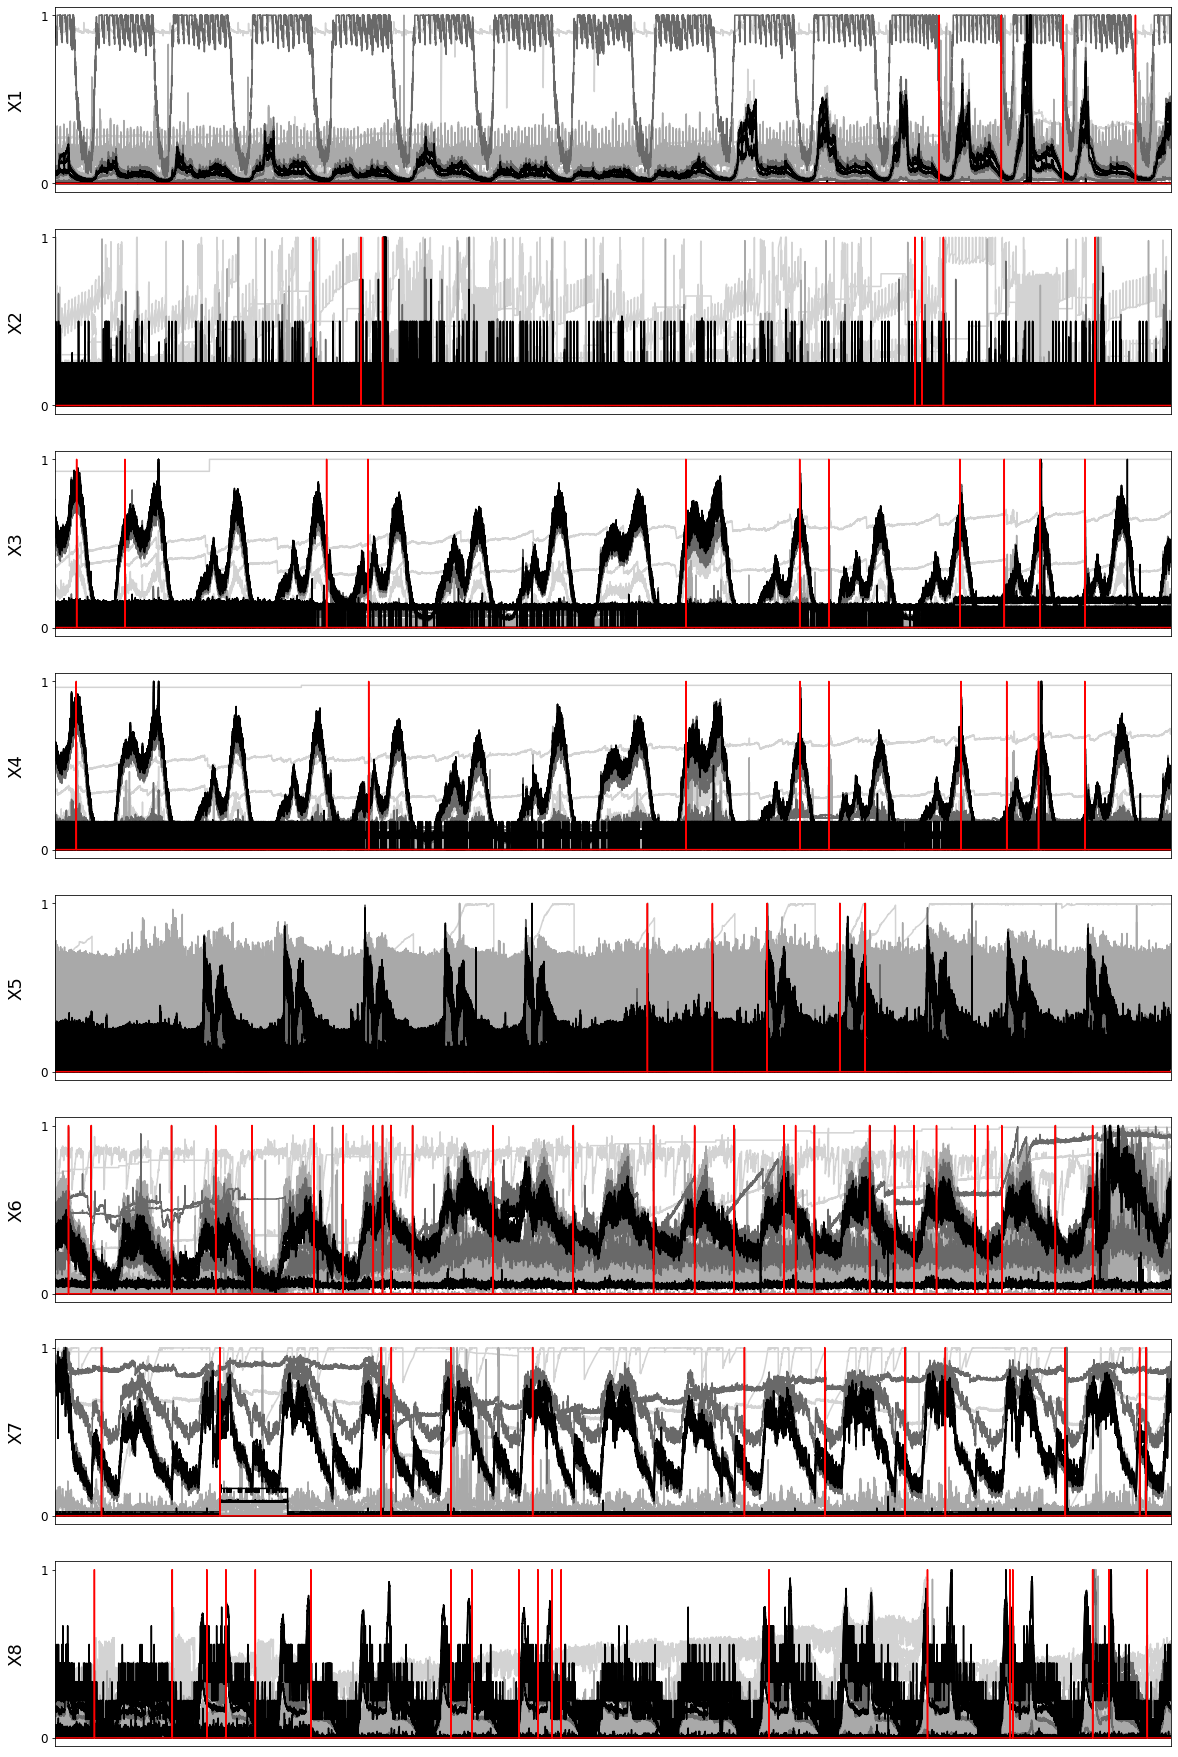

In [5]:
data_plotter = DataPlotter(figsize=(20, 32), x_visible = False, x_len = 20000)
data_plotter.plt_time_series_with_events(time_series, event_sequences)

## Dataset Tiling

Anomaly detection dataset의 특성 상 한 시계열 데이터에 대하여 서로 다른 사건이 적은 반복 횟수로 나타나는 경우가 많다. 따라서, 이러한 경우에 한하여 시계열과 사건 시퀀스를 tiling하여 반복 횟수를 증가시킨다.

In [6]:
REPEAT_TIME = 4
for i in range(len(time_series)):
  time_series[i] = np.tile(time_series[i], reps=[REPEAT_TIME, 1])

event_sequences_tiled = []
for e in range(len(event_sequences)):
  es_set = event_sequences[e]
  es_set_tmp = []

  for es in es_set:
    es_tmp = []

    for r in range(REPEAT_TIME):
      es_tmp = es_tmp + [(i + r*int(time_series[e].shape[0]/REPEAT_TIME)) for i in es]
    es_set_tmp.append(es_tmp)
  event_sequences_tiled.append(es_set_tmp)

## Run CETS

In [7]:
warnings.filterwarnings("error")
_cets = CETS(time_series, event_sequences_tiled, 0, ts_ratio = REPEAT_TIME, 
              sub_len_max = 200, sub_len_min = 100, r=3, alpha = 2.58, nn_dis_threshold = 0.0025)

In [8]:
output = _cets.run_cets()

Time-series X1 dim 1 (+)-> Effect 1
Time-series X1 dim 1 (+)-> Effect 2
Time-series X1 dim 1 (+)-> Effect 3
Time-series X1 dim 1 (+)-> Effect 4
Time-series X1 dim 1 (+)-> Effect 5
Time-series X1 dim 2 (-)-> Effect 2
Time-series X1 dim 2 (-)-> Effect 3
Time-series X1 dim 2 <-(-) Effect 5
Time-series X1 dim 3 (-)-> Effect 1
Time-series X1 dim 3 (-)-> Effect 2
Time-series X1 dim 3 (-)-> Effect 3
Time-series X1 dim 3 (-)-> Effect 5
Time-series X1 dim 4 (-)-> Effect 1
Time-series X1 dim 4 (-)-> Effect 2
Time-series X1 dim 4 (-)-> Effect 3
Time-series X1 dim 4 (-)-> Effect 5
Time-series X1 dim 6 (-)-> Effect 1
Time-series X1 dim 6 (-)-> Effect 5
Time-series X1 dim 7 (+)-> Effect 1
Time-series X1 dim 7 (-)-> Effect 3
Time-series X1 dim 7 (-)-> Effect 4
Time-series X1 dim 7 (-)-> Effect 5
Time-series X1 dim 9 ( )-> Effect 1
Time-series X1 dim 9 <-( ) Effect 2
Time-series X1 dim 9 <-(+) Effect 3
Time-series X1 dim 9 <-(+) Effect 4
Time-series X1 dim 9 ( )-> Effect 5
Time-series X1 dim 10 (+)-> 

In [9]:
scoring = Scoring(interpretation_labels, correlation_types, output, cal_type='exist')
print(scoring.precision())
print(scoring.recall())
print(scoring.f1_score())

0.3447570332480818
0.903485254691689
0.49907441688263604


In [10]:
pearson = Pearson(time_series, event_sequences_tiled, p = 0.005)
output_p = pearson.run_pearson()

In [11]:
scoring_p = Scoring(interpretation_labels, correlation_types, output_p, correlat_alg = 'pearson', cal_type='exist')
print(scoring_p.precision())
print(scoring_p.recall())
print(scoring_p.f1_score())

0.3173277661795407
0.4075067024128686
0.3568075117370892
